# geom #1

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
L = 1.0;   E = 200e9;   I = 1e-6;   q = 10000.0
def analytical(x):
    return - (q / (E * I)) * (x**4 / 24 - x**3 / 6 + x**2 / 4)

In [11]:
geom = dde.geometry.Interval(0, L)

In [12]:
# ODE
def pde(x ,y):
    dy_xx = dde.grad.hessian(y, x)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + (q / (E * I))

In [13]:
# left
def boundary_value_l(x):
    return 0

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

# right
def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

def boundary_second_derivative(x, y, _):
    return ddy(x, y)

def boundary_third_derivative(x, y, _):
    return dddy(x, y)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)

In [14]:
bc_dbc = dde.icbc.DirichletBC(geom, boundary_value_l, boundary_l)
bc_nbc = dde.icbc.NeumannBC(geom, boundary_value_l, boundary_l)

bc_obc1 = dde.icbc.OperatorBC(geom, boundary_second_derivative, boundary_r)
bc_obc2 = dde.icbc.OperatorBC(geom, boundary_third_derivative, boundary_r)

In [15]:
bc = [bc_dbc, bc_nbc, bc_obc1, bc_obc2]
data = dde.data.PDE(geom, pde, bc, 15, 2 , solution=analytical, num_test=100)

In [16]:
layer_size = [1] + [30]*3 +[1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.060416 s

'compile' took 1.477816 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.31e-03, 0.00e+00, 2.38e-03, 7.69e-04, 2.74e-04]    [1.31e-03, 0.00e+00, 2.38e-03, 7.69e-04, 2.74e-04]    [7.27e+00]    
1000      [2.10e-06, 9.27e-13, 1.78e-11, 2.97e-09, 1.46e-09]    [1.52e-06, 9.27e-13, 1.78e-11, 2.97e-09, 1.46e-09]    [2.82e-03]    
2000      [1.66e-06, 9.68e-14, 9.92e-12, 1.82e-09, 9.20e-11]    [1.20e-06, 9.68e-14, 9.92e-12, 1.82e-09, 9.20e-11]    [5.47e-04]    
3000      [1.40e-06, 2.57e-14, 4.13e-12, 1.24e-09, 2.90e-11]    [1.01e-06, 2.57e-14, 4.13e-12, 1.24e-09, 2.90e-11]    [2.42e-04]    
4000      [1.20e-06, 2.00e-11, 1.70e-10, 1.14e-09, 5.88e-11]    [8.70e-07, 2.00e-11, 1.70e-10, 1.14e-09, 5.88e-11]    [3.31e-03]    

Best model at step 4000:
  train loss: 1.20e-06
  test loss: 8.72e-07
 

<function matplotlib.pyplot.show(close=None, block=None)>

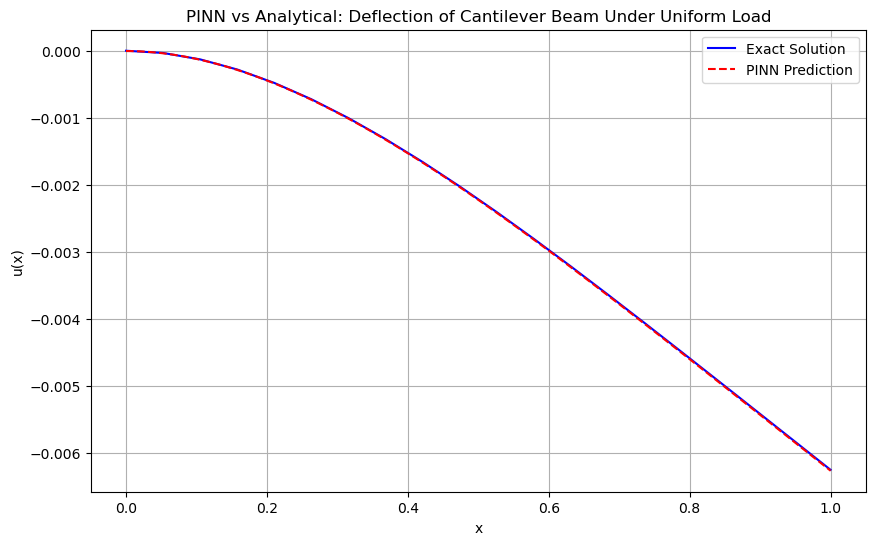

In [17]:
x_values_pinn = np.linspace(0, L, 100).reshape(-1, 1)
x_values_exact = np.linspace(0, L, 20).reshape(-1, 1)

y_pred = model.predict(x_values_pinn)
y_exact = analytical(x_values_exact)


plt.figure(figsize=(10, 6))
plt.plot(x_values_exact, y_exact, label="Exact Solution", color="blue")
plt.plot(x_values_pinn, y_pred, label="PINN Prediction", color="red", linestyle="--")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN vs Analytical: Deflection of Cantilever Beam Under Uniform Load")
plt.legend()
plt.grid()
plt.show